In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from data_cleanup import *

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [30]:
df = load_reduced_df()

In [65]:
target_col = 'bci_bci' # 'wbgi_cce'

In [66]:
df

,ccode,cname,year,ccode_qog,cname_qog,ccodealp,ccodecow,version,cname_year,ccodealp_year,...,wwbi_sprpempp,wwbi_sprpemps,wwbi_sprpempt,wwbi_spupempn,wwbi_spupempp,wwbi_spupemps,wwbi_spupempt,wwbi_tertiarypubsec,region,sub-region
59,4,Afghanistan,2005,4,Afghanistan,AFG,700.0,QoGStdTSjan22,Afghanistan 2005,AFG05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asia,Southern Asia
61,4,Afghanistan,2007,4,Afghanistan,AFG,700.0,QoGStdTSjan22,Afghanistan 2007,AFG07,...,0.128090,0.117742,0.012774,0.168941,0.096384,0.446096,0.288579,0.677745,Asia,Southern Asia
62,4,Afghanistan,2008,4,Afghanistan,AFG,700.0,QoGStdTSjan22,Afghanistan 2008,AFG08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asia,Southern Asia
63,4,Afghanistan,2009,4,Afghanistan,AFG,700.0,QoGStdTSjan22,Afghanistan 2009,AFG09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asia,Southern Asia
64,4,Afghanistan,2010,4,Afghanistan,AFG,700.0,QoGStdTSjan22,Afghanistan 2010,AFG10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asia,Southern Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14930,894,Zambia,2013,894,Zambia,ZMB,551.0,QoGStdTSjan22,Zambia 2013,ZMB13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Africa,Sub-Saharan Africa
14931,894,Zambia,2014,894,Zambia,ZMB,551.0,QoGStdTSjan22,Zambia 2014,ZMB14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Africa,Sub-Saharan Africa
14932,894,Zambia,2015,894,Zambia,ZMB,551.0,QoGStdTSjan22,Zambia 2015,ZMB15,...,0.172776,0.578589,0.219818,0.017781,0.109138,0.342219,0.530862,0.501821,Africa,Sub-Saharan Africa
14933,894,Zambia,2016,894,Zambia,ZMB,551.0,QoGStdTSjan22,Zambia 2016,ZMB16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Africa,Sub-Saharan Africa


- group by country
- divide in train and test datasets
- check that each contry has enough points
- check how regions are balanced
- 2 versions: all cols and cols without nulls
- run feature selection on all cols and cols wout nulls
- run a simple model ? check how feature selection performs?
- check for highly correlated cols in feat selection?

### Check that each country has enough points

In [67]:
df.groupby('cname').year.nunique().agg(['mean', 'min', 'max'])

mean    15.902299
min      1.000000
max     19.000000
Name: year, dtype: float64

In [68]:
df.groupby('cname').year.nunique()[df.groupby('cname').year.nunique() < 5]

cname
Fiji    1
Name: year, dtype: int64

In [69]:
df[df.cname == 'Fiji']

,ccode,cname,year,ccode_qog,cname_qog,ccodealp,ccodecow,version,cname_year,ccodealp_year,...,wwbi_sprpempp,wwbi_sprpemps,wwbi_sprpempt,wwbi_spupempn,wwbi_spupempp,wwbi_spupemps,wwbi_spupempt,wwbi_tertiarypubsec,region,sub-region
4438,242,Fiji,2005,242,Fiji,FJI,950.0,QoGStdTSjan22,Fiji 2005,FJI05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oceania,Melanesia


### Check how regions are balanced

In [70]:
region_count = pd.DataFrame(df.groupby('sub-region').cname.count()).reset_index(drop=False)
region_count.columns = ['sub-region', 'num of samples']

region_country_count = pd.DataFrame(df.groupby('sub-region').cname.nunique()).reset_index(drop=False)
region_country_count.columns = ['sub-region', 'num of countries']

region_info_df = region_count.merge(region_country_count, on='sub-region')
region_info_df = region_info_df.melt(id_vars=['sub-region'], value_vars=['num of samples', 'num of countries'])

Text(0.5, 1.0, 'Regions by number of countries')

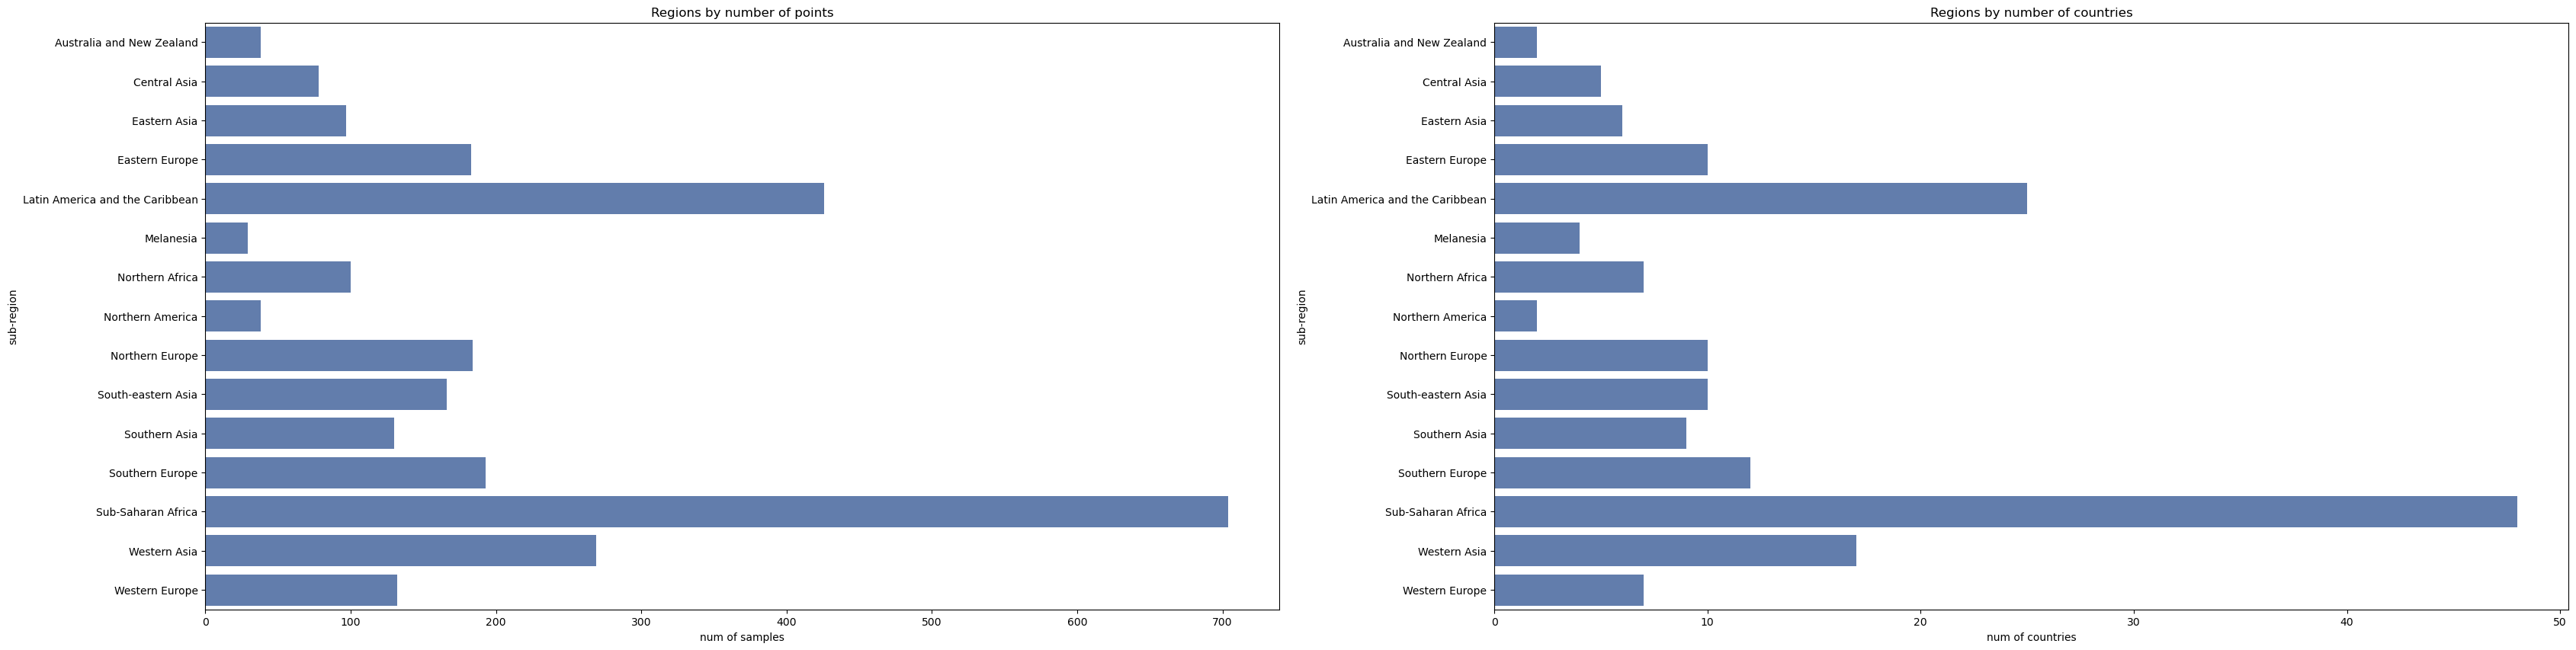

In [71]:
_, ax = plt.subplots(1, 2, figsize=(40, 10))
sns.barplot(data=region_count, y='sub-region', x='num of samples', color='#567ab8', ax=ax[0])
ax[0].set_title('Regions by number of points')
sns.barplot(data=region_country_count, y='sub-region', x='num of countries', color='#567ab8', ax=ax[1])
ax[1].set_title('Regions by number of countries')

### Create test and train datasets

These columns contain dates and are not valid features, hence they are dropped

In [72]:
date_columns = [c for c in df.columns if 'date' in c]
df = df.drop(date_columns, axis=1)

In [73]:
random_state = 424242

In [74]:
country_data = pd.DataFrame(df.groupby('cname')['sub-region'].min())
country_data = country_data.reset_index(drop=False)

In [75]:
country_data

,cname,sub-region
0,Afghanistan,Southern Asia
1,Albania,Southern Europe
2,Algeria,Northern Africa
3,Angola,Sub-Saharan Africa
4,Argentina,Latin America and the Caribbean
...,...,...
169,Venezuela (Bolivarian Republic of),Latin America and the Caribbean
170,Viet Nam,South-eastern Asia
171,Yemen,Western Asia
172,Zambia,Sub-Saharan Africa


Stratify by region, so that each region is in a train and test dataset

In [76]:
X_train, X_test, y_train, y_test = train_test_split(country_data, country_data['cname'], test_size=0.2, random_state=random_state, stratify=country_data['sub-region'])

In [77]:
X_train.groupby('sub-region').cname.nunique()

sub-region
Australia and New Zealand           2
Central Asia                        4
Eastern Asia                        5
Eastern Europe                      8
Latin America and the Caribbean    20
Melanesia                           3
Northern Africa                     6
Northern America                    2
Northern Europe                     8
South-eastern Asia                  8
Southern Asia                       7
Southern Europe                     9
Sub-Saharan Africa                 38
Western Asia                       13
Western Europe                      6
Name: cname, dtype: int64

In [78]:
X_test.groupby('sub-region').cname.nunique()

sub-region
Central Asia                        1
Eastern Asia                        1
Eastern Europe                      2
Latin America and the Caribbean     5
Melanesia                           1
Northern Africa                     1
Northern Europe                     2
South-eastern Asia                  2
Southern Asia                       2
Southern Europe                     3
Sub-Saharan Africa                 10
Western Asia                        4
Western Europe                      1
Name: cname, dtype: int64

Check that each country is either in train or test dataset

In [79]:
set(X_train.cname.unique()).intersection(X_test.cname.unique())

set()

In [80]:
feat_col_start_full = 10
feat_col_start_reduced = 9

In [81]:
df_cols_reduced = df.dropna(how='any', axis=1)

In [82]:
corr_cols = ['bci_bci', 'ti_cpi', 'vdem_corr', 'vdem_execorr', 'vdem_jucorrdc', 'vdem_pubcorr', 'wbgi_cce']
feats_cols = [c for c in df.columns[feat_col_start_full:-2] if c not in corr_cols]
feats_cols_reduced = [c for c in df_cols_reduced.columns[feat_col_start_reduced:-2] if c not in corr_cols]

In [83]:
def divide_into_test_train(df, target, feats_cols, corr_column=target_col):
    x = df.copy()
    x = x[x.cname.isin(target)]
    y = x.loc[:, corr_column]
    x = x.loc[:, feats_cols]
    return x, y

In [84]:
x_train_full, y_train_full = divide_into_test_train(df, y_train, feats_cols, corr_column=target_col)
x_test_full, y_test_full = divide_into_test_train(df, y_test, feats_cols, corr_column=target_col)

In [85]:
x_train_reduced, y_train_reduced = divide_into_test_train(df_cols_reduced, y_train, feats_cols_reduced, corr_column=target_col)
x_test_reduced, y_test_reduced = divide_into_test_train(df_cols_reduced, y_test, feats_cols_reduced, corr_column=target_col)

### Feature selection

Running feature selection only on reduced (NaNs dropped) df bc feature selection method cannot handle the NaNs

In [86]:
k = 20

In [87]:
feat_selector = SelectKBest(f_regression, k=k)

In [88]:
feat_selector.fit(x_train_reduced, y_train_reduced)

SelectKBest(k=20, score_func=<function f_regression at 0x7f233db376d0>)

"Best features" according to the select k best:

In [89]:
best_feats = feat_selector.get_feature_names_out(x_train_reduced.columns)
best_feats

array(['fh_cl', 'ihme_hle_0104m', 'ihme_hle_0104t', 'ihme_lifexp_0104f',
       'ihme_lifexp_0104m', 'ihme_lifexp_0104t', 'vdem_delibdem',
       'vdem_egal', 'vdem_egaldem', 'vdem_exbribe', 'vdem_excrptps',
       'vdem_exembez', 'vdem_exthftps', 'vdem_libdem', 'vdem_liberal',
       'wbgi_gee', 'wbgi_pve', 'wbgi_rle', 'wbgi_rqe', 'wbgi_vae'],
      dtype=object)

Feats and what they mean:
- bci_bcistd - Standard deviation of The Bayesian Corruption Indicator
- fh_cl - Civil Liberties
- fh_pr - Political Rights
- fh_status - Freedom Status
- vdem_delibdem - Deliberative democracy index
- vdem_edcomp_thick - Electoral component index
- vdem_egal - Egalitarian component index
- vdem_egaldem - Egalitarian democracy index
- vdem_exbribe - Executive bribery and corrupt exchanges
- vdem_excrptps - Public sector corrupt exchanges
- vdem_exembez - Executive embezzlement and theft
- vdem_exthftps - Public sector theft
- vdem_libdem - Liberal democracy index
- vdem_liberal - Liberal component index
- vdem_mecorrpt - Media corrupt
- vdem_partipdem - Participatory democracy index
- vdem_polyarchy - Electoral democracy index
- wbgi_ccs - Control of Corruption, Standard Error[s]
- wbgi_gee - Government Effectiveness, Estimate[e]
- wbgi_pv[e][n][s] - Political Stability and Absence of Violence/Terrorism, Estimate[e], Number of Sources[n], Standard Error[s]
- wbgi_rle - Rule of Law, Estimate[e]
- wbgi_rqe - Regulatory Quality, Estimate[e]
- wbgi_vae - Voice and Accountability, Estimate[e]
- ihme_hle_0104[f][m][t] - Healthy Life Years 1-4 Years, Females[f], Males[m], Both sexes[t]
- ihme_lifexp_0104[f][m][t] - Life Expectancy 1-4 Years, Females[f], Males[m], Both sexes[t]

Kick out columns directly related to corruption:

In [90]:
# corruption_cols = ['vdem_exbribe', 'vdem_excrptps', 'vdem_exembez', 'vdem_exthftps', 'vdem_mecorrpt']
corruption_cols = ['bci_bcistd', 'vdem_exbribe', 'vdem_excrptps', 'vdem_exembez', 'vdem_exthftps', 'vdem_mecorrpt', 'wbgi_ccs', 'wbgi_ccn']
best_feats = [f for f in best_feats if f not in corruption_cols]

In [91]:
# sns.pairplot(x_train_reduced, vars=best_feats)

In [92]:
cm = x_train_reduced[best_feats].corr()
cm = cm.where(np.triu(np.ones(cm.shape), k=1).astype(bool))
cm = cm.reset_index(drop=False)
cm = cm.melt(id_vars='index', var_name='second_col', value_name='corr')
cm.columns = ['first_col', 'second_col', 'corr_id']
cm = cm[cm.first_col != cm.second_col]
cm = cm.dropna()

In [93]:
highly_corr = cm[cm.corr_id.abs() > 0.85].copy()

In [94]:
for i, r in highly_corr.iterrows():
    ws_max = 25
    first_ws = ' ' * (ws_max - len(r.first_col))
    second_ws = ' ' * (ws_max - len(r.second_col))
    print(f'{r.first_col}{first_ws}{r.second_col}{second_ws}{r.corr_id:.2f}')

ihme_hle_0104m           ihme_hle_0104t           0.99
ihme_hle_0104m           ihme_lifexp_0104f        0.95
ihme_hle_0104t           ihme_lifexp_0104f        0.99
ihme_hle_0104m           ihme_lifexp_0104m        1.00
ihme_hle_0104t           ihme_lifexp_0104m        0.98
ihme_lifexp_0104f        ihme_lifexp_0104m        0.95
ihme_hle_0104m           ihme_lifexp_0104t        0.98
ihme_hle_0104t           ihme_lifexp_0104t        1.00
ihme_lifexp_0104f        ihme_lifexp_0104t        0.99
ihme_lifexp_0104m        ihme_lifexp_0104t        0.99
fh_cl                    vdem_delibdem            -0.91
fh_cl                    vdem_egaldem             -0.91
vdem_delibdem            vdem_egaldem             0.96
vdem_egal                vdem_egaldem             0.91
fh_cl                    vdem_libdem              -0.92
vdem_delibdem            vdem_libdem              0.98
vdem_egaldem             vdem_libdem              0.97
fh_cl                    vdem_liberal             -0.89
vdem_d

In [95]:
highly_corr.loc[:, 'corr_id'] = highly_corr.corr_id.abs()
highly_corr_agg = highly_corr.groupby('first_col').agg({'second_col': 'count', 'corr_id': 'mean'})
highly_corr_agg

,second_col,corr_id
first_col,,
fh_cl,5,0.919599
ihme_hle_0104m,4,0.979500
ihme_hle_0104t,3,0.987453
ihme_lifexp_0104f,2,0.969914
ihme_lifexp_0104m,1,0.986827
vdem_delibdem,4,0.952767
vdem_egal,1,0.908470
vdem_egaldem,3,0.936191
vdem_libdem,2,0.951804


In [96]:
best_feats_reduced = [f for f in best_feats if f not in highly_corr_agg[highly_corr_agg.second_col > 1].index.values]

In [97]:
x_train_reduced[best_feats_reduced].corr()

,ihme_lifexp_0104m,ihme_lifexp_0104t,vdem_egal,vdem_liberal,wbgi_pve,wbgi_rle,wbgi_rqe,wbgi_vae
ihme_lifexp_0104m,1.000000,0.986827,0.501579,0.414821,0.410289,0.610353,0.599836,0.513300
ihme_lifexp_0104t,0.986827,1.000000,0.542100,0.442678,0.435112,0.621386,0.622032,0.540704
vdem_egal,0.501579,0.542100,1.000000,0.803709,0.693310,0.806885,0.746250,0.824399
vdem_liberal,0.414821,0.442678,0.803709,1.000000,0.593143,0.744200,0.752069,0.919363
wbgi_pve,0.410289,0.435112,0.693310,0.593143,1.000000,0.788994,0.716135,0.680176
wbgi_rle,0.610353,0.621386,0.806885,0.744200,0.788994,1.000000,0.932697,0.833988
wbgi_rqe,0.599836,0.622032,0.746250,0.752069,0.716135,0.932697,1.000000,0.841702
wbgi_vae,0.513300,0.540704,0.824399,0.919363,0.680176,0.833988,0.841702,1.000000


Feats and what they mean:
- vdem_egal - Egalitarian component index
- vdem_polyarchy - Electoral democracy index
- wbgi_pve - Political Stability and Absence of Violence/Terrorism, Estimate
- wbgi_rle - Rule of Law, Estimate
- wbgi_rqe - Regulatory Quality, Estimate
- wbgi_vae - Voice and Accountability, Estimate

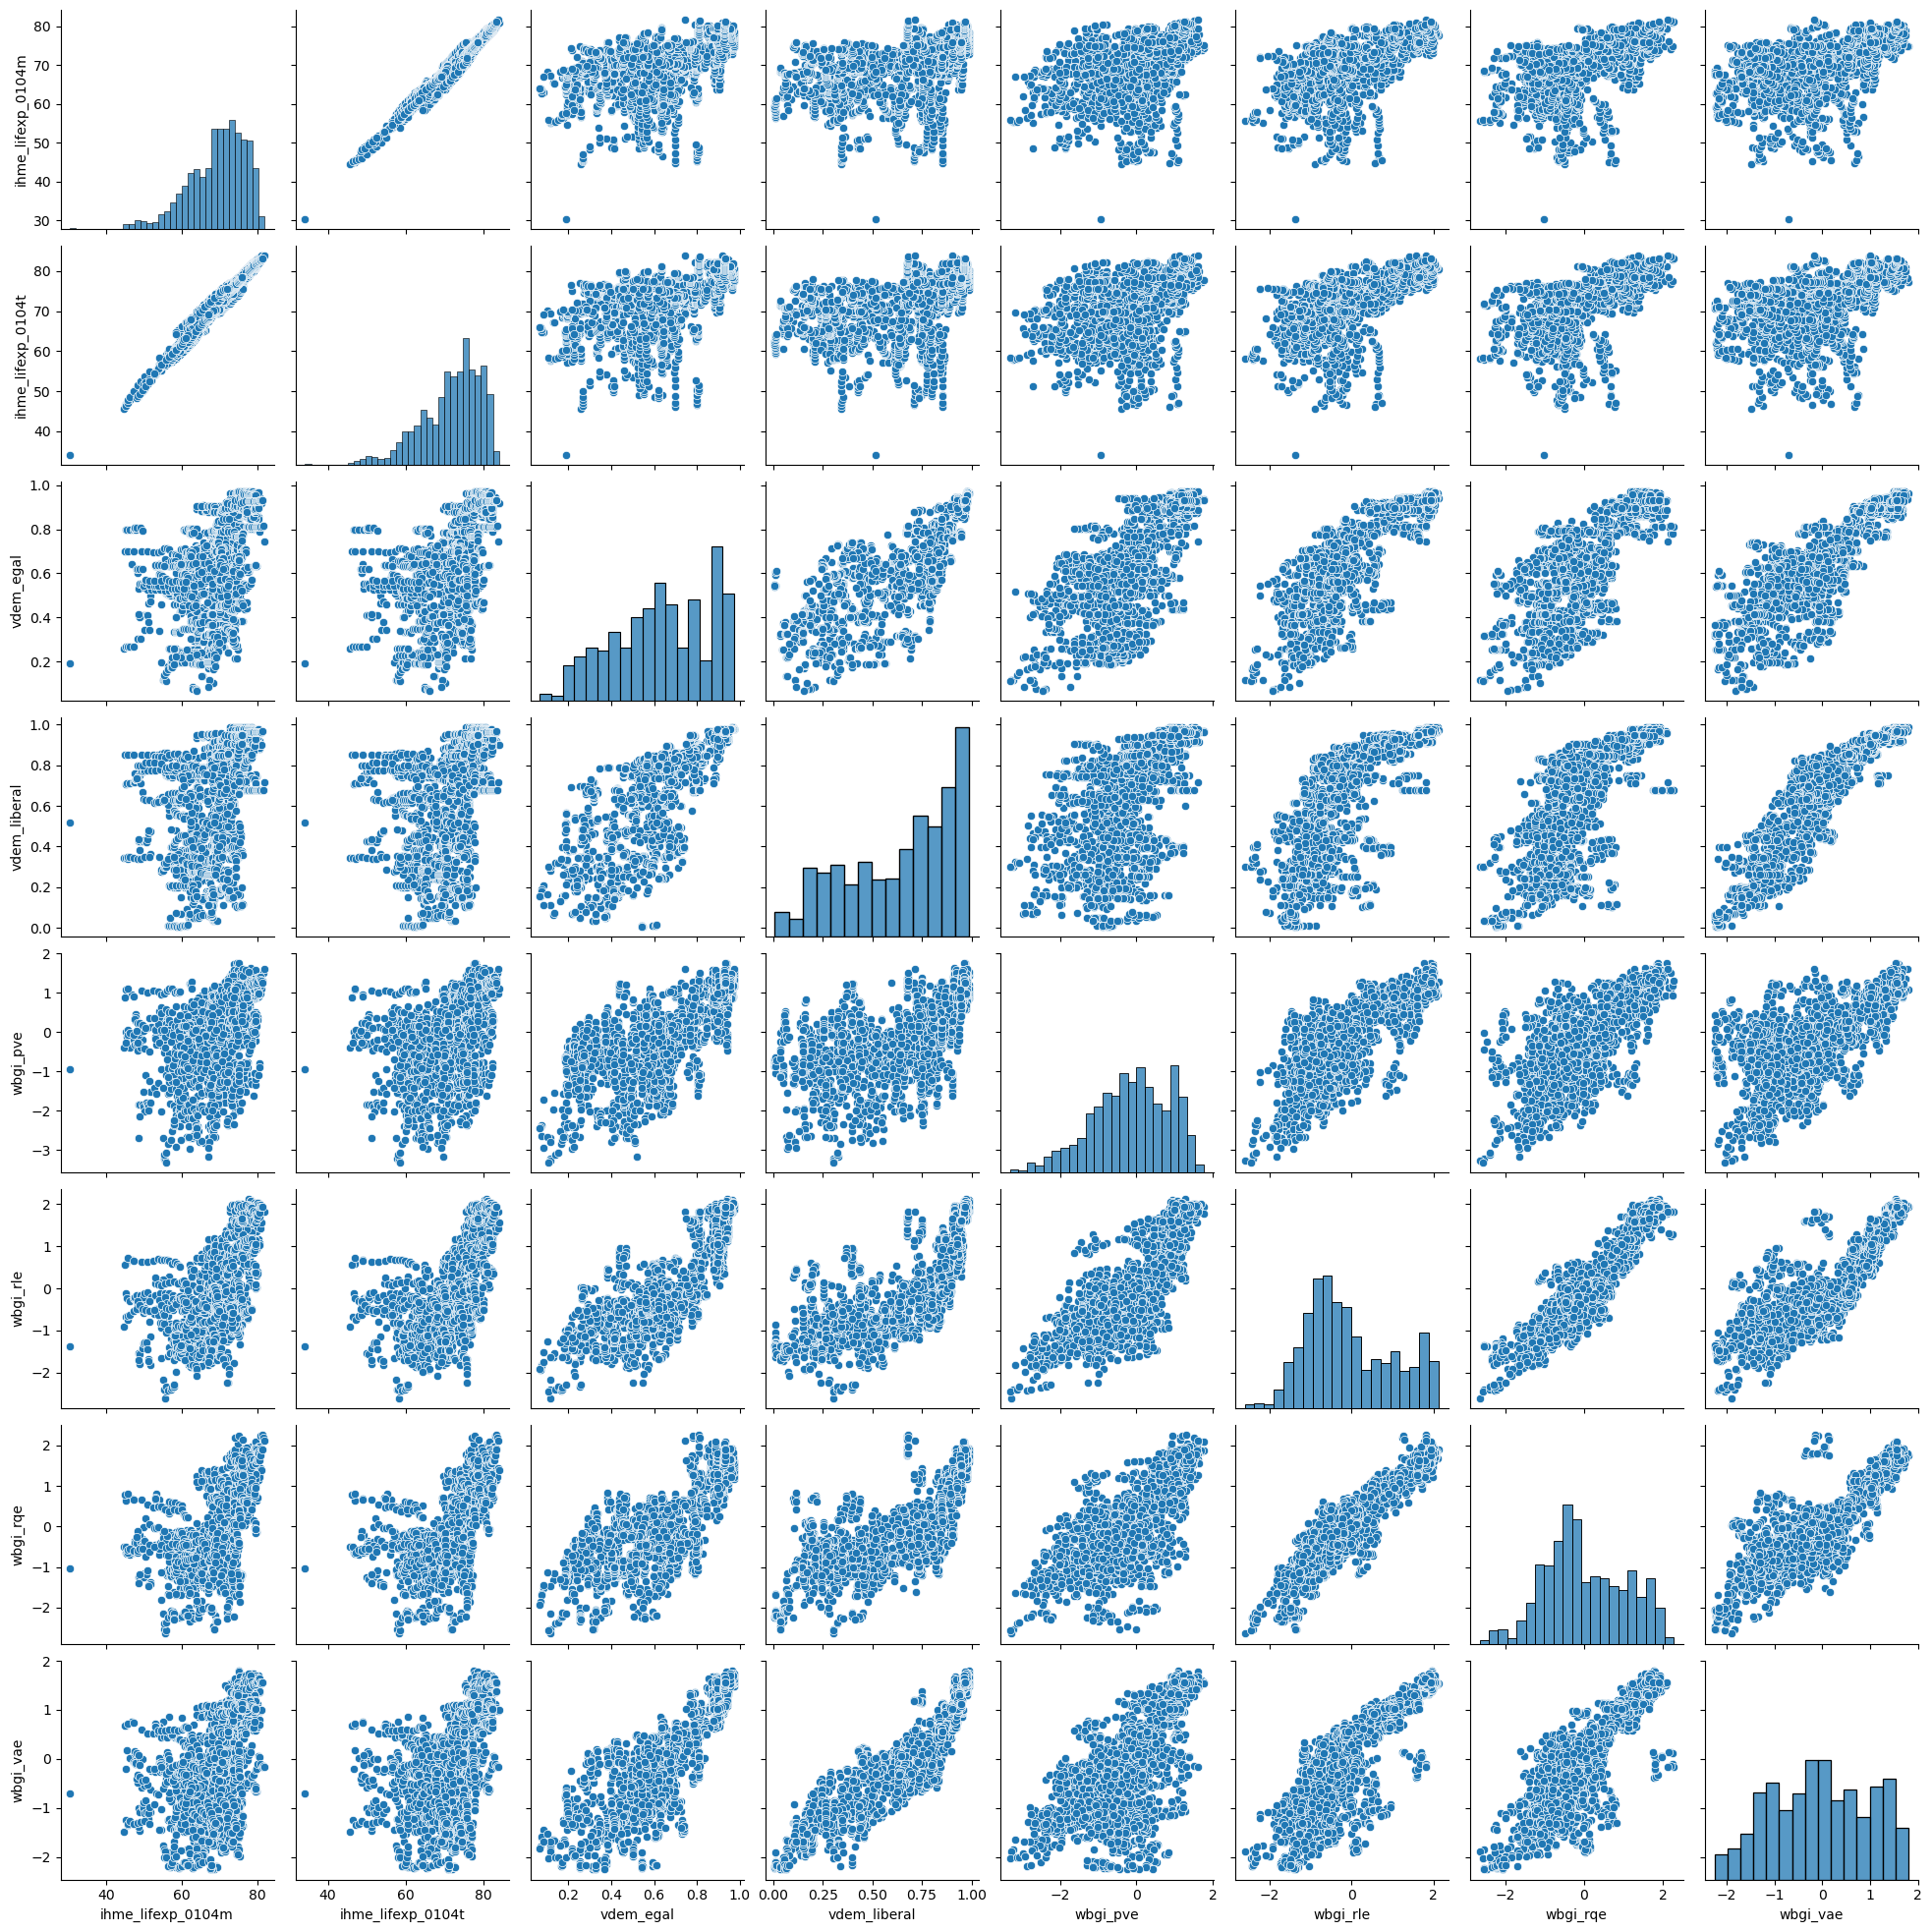

In [98]:
sns.pairplot(x_train_reduced, vars=best_feats_reduced)

### Feature selection evaluation

In [99]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as rmse

In [100]:
options = ['full', 'best', 'best_reduced']

In [101]:
rms = {}
rms['full'] = KNeighborsRegressor(n_neighbors=20)
rms['best'] = KNeighborsRegressor(n_neighbors=20)
rms['best_reduced'] = KNeighborsRegressor(n_neighbors=20)

In [102]:
feats = {}
feats['full'] = x_train_reduced.columns
feats['best'] = best_feats
feats['best_reduced'] = best_feats_reduced

In [103]:
opt = 'best_reduced'
rms[opt].fit(x_train_reduced[feats[opt]], y_train_reduced)
y_pred = rms[opt].predict(x_test_reduced[feats[opt]])
print(f'rmse: {rmse(y_test_reduced, y_pred, squared=True)}')
print(f'r2: {r2(y_test_reduced, y_pred)}')

rmse: 97.4124475861682
r2: 0.520791029714242


In [104]:
for opt in options:
    print(f'current model: {opt}')
    rms[opt].fit(x_train_reduced[feats[opt]], y_train_reduced)
    y_pred = rms[opt].predict(x_test_reduced[feats[opt]])
    print(f'rmse: {rmse(y_test_reduced, y_pred, squared=True)}')
    print(f'r2: {r2(y_test_reduced, y_pred)}')
    print()  

current model: full
rmse: 164.74514704124422
r2: 0.1895558090420023

current model: best
rmse: 97.29971835491514
r2: 0.5213455877832412

current model: best_reduced
rmse: 97.4124475861682
r2: 0.520791029714242

